In [3]:
import copy
import os
from tqdm import tqdm
import numpy as np
from math import floor

from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import DataCollatorForCompletionOnlyLM
from peft import get_peft_model, get_peft_model_state_dict, set_peft_model_state_dict, prepare_model_for_kbit_training

from utils import *
from utils.utils import default_evaluation, save_dataset_test

from dataclasses import dataclass, field, asdict
from typing import Optional
from transformers import HfArgumentParser, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig
import os
import json
from accelerate import Accelerator
import torch
from datetime import datetime, timedelta

from trl import SFTTrainer
from transformers import TrainerCallback

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
dataset_name = 'multitask'
model_name = 'HuggingFaceTB/SmolLM-135M'

In [6]:
dataset, dataset_test = get_dataset(dataset_name, None, 0.8)
dataset =      process_sft_dataset(dataset_name, dataset,      400000)
dataset_test = process_sft_dataset(dataset_name, dataset_test, 400000)

Using the latest cached version of the module from /home/gabriel.talasso/.cache/huggingface/modules/datasets_modules/datasets/Samsung--samsum/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e (last modified on Tue Mar 11 13:33:01 2025) since it couldn't be found locally at Samsung/samsum, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/gabriel.talasso/.cache/huggingface/modules/datasets_modules/datasets/Harvard--gigaword/cd40ed63b2731b6da1f321fba3f70998c2d7de54730f50e0c20f6ac37f323a40 (last modified on Tue Mar 11 13:37:41 2025) since it couldn't be found locally at Harvard/gigaword, or remotely on the Hugging Face Hub.


Dataset Splited into TRAIN: 71668 and TEST: 17917


In [7]:
local_datasets = []
tasks = ['boolq', 'gigaword', 'samsum', 'webnlg']
n_clients_in_cluster = 4 // len(tasks)

for i in range(4):
    task = tasks[i // n_clients_in_cluster]
    cluster_dataset = dataset.filter(lambda x: x['task'] == task)
    cluster_dataset = cluster_dataset.shuffle(seed=0)

    local_datasets.append(cluster_dataset.shard(n_clients_in_cluster, i % n_clients_in_cluster))

In [8]:
EVAL_SIZE = 1000

In [42]:
local_datasets_test = []
for i in range(4):
    task = tasks[i // n_clients_in_cluster]
    cluster_dataset_test = dataset_test.filter(lambda x: x['task'] == task)
    cluster_dataset_test = cluster_dataset_test.shuffle(seed=0)

    aux = cluster_dataset_test.shard(n_clients_in_cluster, i % n_clients_in_cluster)
    aux = aux.select(range(EVAL_SIZE))  # Limit to 1000 samples for testing
    local_datasets_test.append(aux)


In [19]:
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
# Copy the model to each device
device_map = {"": Accelerator().local_process_index}
torch_dtype = torch.bfloat16

In [20]:
peft_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

In [21]:
def get_model_and_tokenizer():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map=device_map,
        trust_remote_code=True,
        torch_dtype=torch_dtype,
    )
    print(f"Model loaded from {model_name}")


    model = prepare_model_for_kbit_training(
                model, use_gradient_checkpointing=True
            )

    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

    model.enable_input_require_grads()

    # ===== Define the global and local models =====
    global_dict = copy.deepcopy(get_peft_model_state_dict(model))
    local_dict_list = [copy.deepcopy(global_dict) for i in range(4)]

    # ===== Define the tokenizer =====
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, padding_side="right")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.unk_token   # following vicuna

    if tokenizer.eos_token == tokenizer.unk_token or tokenizer.pad_token == tokenizer.eos_token:
        tokenizer.add_special_tokens({'pad_token': '<pad>'})
        print(f"Pad token is set to {tokenizer.pad_token}.")

    print('Special tokens:', tokenizer.special_tokens_map)
    model.resize_token_embeddings(len(tokenizer))

    return model, tokenizer

In [22]:
max_steps=100
num_train_epochs=1
num_rounds=100
eval_round="10,25,50,100"
batch_size=16
batch_size_eval=128
gradient_accumulation_steps=1
seq_length=1024
num_clients=8
sample_clients=8
lora_r=8
lora_alpha=16  # twice of lora_r
lr=5e-4

In [23]:
output_dir = 'output_centralized_tests50'
eval_batch_size = 128

In [24]:
training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=lr,
        logging_steps=10,
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,
        report_to=None,
        save_steps=1000,
        save_total_limit=10,
        push_to_hub=False,
        hub_model_id=None,
        gradient_checkpointing=True,
        lr_scheduler_type="constant",
        #max_seq_length=script_args.seq_length,
    )

In [25]:
_,  tokenizer = get_model_and_tokenizer()
formatting_prompts_func, response_template = get_formatting_prompts_func('alpaca', tokenizer.eos_token)
if response_template:
    response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)[2:]   # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]` for Llama2
    data_collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)
    packing = False
else:
    data_collator = None
    packing = True

Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}


In [26]:
def default_evaluation(model, tokenizer, dataset, client_id, round, formatting_prompts_func, script_args, cluster_id=None):
    """
    Default evaluation function to compute model responses and ROUGE scores.
    """
    print("Evaluating model...")
    # Apply template to dataset
    dataset = utils.apply_template_to_dataset(dataset, formatting_prompts_func)
    dataset_length = len(dataset)
    eval_responses = utils.get_model_responses(model, tokenizer, dataset, batch_size=eval_batch_size)
    dataset_with_responses = dataset.select(range(len(dataset)))
    dataset_with_responses = dataset_with_responses.add_column('model_responses', eval_responses)
    scores = utils.calcule_rogue1(eval_responses, dataset_with_responses)
    print(f"Evaluation scores: {scores}")

    #verify output directory
    if not os.path.exists(os.path.join(output_dir, "evals")):
        os.makedirs(os.path.join(output_dir, "evals"))
    # Save evaluation results
    with open(os.path.join(output_dir, f"evals/rouge_client_{client_id}_cluster_{cluster_id}_round_{round}.json"), 'w') as f:
        scores['dataset_length'] = dataset_length
        json.dump(scores, f, indent=4)

In [27]:
from safetensors.torch import load_file, save_file


In [18]:
for i, local_dataset in enumerate(local_datasets):

    model, tokenizer = get_model_and_tokenizer()

    test_dataset = local_datasets_test[i]

    print(f"Evaluating Pretrained Model on {test_dataset} for task {i}")
    default_evaluation(
                    model=model,
                    tokenizer=tokenizer,
                    dataset=test_dataset,
                    client_id=i,
                    round=0, #with respect to model from the previous round
                    formatting_prompts_func=formatting_prompts_func,
                    script_args=None,
                    cluster_id=0,
                )
    
    trainer = SFTTrainer(
            model=model,
            processing_class=tokenizer,
            args=training_args,
            #max_seq_length=script_args.seq_length,
            train_dataset=local_dataset,
            formatting_func=formatting_prompts_func,
            data_collator=data_collator,
            #packing=packing,
            #dataset_text_field=dataset_text_field,
        )

    print('Training model...')
    trainer.train()

    print('Saving model...')
    model.save_pretrained(os.path.join(output_dir, f"model_client_{i}_cluster_0_round_0"))

    print('Eval_posting model...')
    default_evaluation(
                    model=model,
                    tokenizer=tokenizer,
                    dataset=test_dataset,
                    client_id=i,
                    round=1, 
                    formatting_prompts_func=formatting_prompts_func,
                    script_args=None,
                    cluster_id=0,
                )
    
    print('Cleaning up...')
    del model
    del tokenizer
    torch.cuda.empty_cache()
    print('Done with client', i)
    

Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Evaluating Pretrained Model on Dataset({
    features: ['question', 'answer', 'passage', 'instruction', 'response', 'task', 'gem_id', 'gem_parent_id', 'input', 'target', 'references', 'category', 'webnlg_id', 'id', 'dialogue', 'summary', 'document'],
    num_rows: 1000
}) for task 0
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [01:23<09:44, 83.51s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [02:44<08:12, 82.01s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [04:23<07:29, 89.80s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [06:10<06:26, 96.63s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [07:31<04:33, 91.04s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [08:44<02:49, 84.74s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [10:05<01:23, 83.52s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [11:10<00:00, 83.84s/it]


Evaluation scores: {'rouge1': np.float64(5.613313226800335e-05), 'rouge2': np.float64(0.0), 'rougeL': np.float64(5.8149443965857975e-05), 'rougeLsum': np.float64(5.7458162965534884e-05)}


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training model...


Step,Training Loss
10,7.672300
20,3.136100
30,0.794800
40,0.354700
50,0.339300
60,0.362600
70,0.353900
80,0.338400
90,0.314200
100,0.326600


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saving model...


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Generating responses for batch 1/8


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 12%|█▎        | 1/8 [00:04<00:28,  4.14s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [00:07<00:22,  3.82s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [00:12<00:22,  4.43s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [00:18<00:20,  5.01s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [00:22<00:13,  4.52s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [00:25<00:08,  4.03s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [00:29<00:03,  3.91s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


Evaluation scores: {'rouge1': np.float64(0.628), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.627), 'rougeLsum': np.float64(0.628)}
Cleaning up...
Done with client 0
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Evaluating Pretrained Model on Dataset({
    features: ['question', 'answer', 'passage', 'instruction', 'response', 'task', 'gem_id', 'gem_parent_id', 'input', 'target', 'references', 'category', 'webnlg_id', 'id', 'dialogue', 'summary', 

  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:49<05:48, 49.82s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:40<05:03, 50.51s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [02:31<04:11, 50.39s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [03:20<03:20, 50.17s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [04:11<02:30, 50.15s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [05:00<01:40, 50.01s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [05:50<00:49, 49.91s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [06:34<00:00, 49.26s/it]


Evaluation scores: {'rouge1': np.float64(0.008190108799093227), 'rouge2': np.float64(0.0028405914700258142), 'rougeL': np.float64(0.007499066123792117), 'rougeLsum': np.float64(0.007336903565406592)}


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training model...


Step,Training Loss
10,4.295000
20,3.680300
30,3.239500
40,3.191600
50,3.192300
60,3.093700
70,2.917900
80,2.740600
90,3.085200
100,2.990900


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saving model...


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:51<05:58, 51.20s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:43<05:09, 51.58s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [02:33<04:16, 51.28s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [03:25<03:25, 51.30s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [04:16<02:33, 51.22s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [05:07<01:42, 51.12s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [05:58<00:51, 51.01s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [06:43<00:00, 50.49s/it]


Evaluation scores: {'rouge1': np.float64(0.24244135306916573), 'rouge2': np.float64(0.08746501830972976), 'rougeL': np.float64(0.22105938919622847), 'rougeLsum': np.float64(0.22073849394710499)}
Cleaning up...
Done with client 1
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Evaluating Pretrained Model on Dataset({
    features: ['question', 'answer', 'passage', 'instruction', 'response', 'task', 'gem_id', 'gem_parent_id', 'input', 'target', 'reference

  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [01:53<13:17, 113.97s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [03:47<11:22, 113.79s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [05:18<08:35, 103.15s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [07:10<07:06, 106.73s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [09:03<05:26, 108.93s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [10:38<03:28, 104.28s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [12:51<01:53, 113.73s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [14:26<00:00, 108.30s/it]


Evaluation scores: {'rouge1': np.float64(0.019729008131734126), 'rouge2': np.float64(0.004577493815434987), 'rougeL': np.float64(0.01684521207722834), 'rougeLsum': np.float64(0.016765502998962838)}


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training model...


Step,Training Loss
10,2.943800
20,2.380200
30,2.165700
40,2.068400
50,2.089800
60,2.092400
70,2.057500
80,1.945100
90,1.958400
100,1.964400


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saving model...


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 12%|█▎        | 1/8 [01:53<13:15, 113.71s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [03:46<11:19, 113.30s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [05:16<08:32, 102.60s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [07:08<07:05, 106.29s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [09:01<05:25, 108.57s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [10:36<03:27, 103.93s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [12:49<01:53, 113.46s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [14:23<00:00, 107.98s/it]


Evaluation scores: {'rouge1': np.float64(0.32945939983858774), 'rouge2': np.float64(0.12058495893470517), 'rougeL': np.float64(0.26585045139157215), 'rougeLsum': np.float64(0.2662275709321097)}
Cleaning up...
Done with client 2
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Evaluating Pretrained Model on Dataset({
    features: ['question', 'answer', 'passage', 'instruction', 'response', 'task', 'gem_id', 'gem_parent_id', 'input', 'target', 'references

  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:52<06:08, 52.66s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:49<05:29, 54.95s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [02:44<04:35, 55.06s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [03:42<03:44, 56.20s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [04:36<02:46, 55.40s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [05:34<01:52, 56.37s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [06:31<00:56, 56.59s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [07:19<00:00, 54.94s/it]


Evaluation scores: {'rouge1': np.float64(0.019139384043698034), 'rouge2': np.float64(0.004979117700138286), 'rougeL': np.float64(0.01692801179210806), 'rougeLsum': np.float64(0.016592589075911525)}


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training model...


Step,Training Loss
10,2.141600
20,1.642100
30,1.544600
40,1.423300
50,1.322800
60,1.414100
70,1.321300
80,1.304500
90,1.301200
100,1.205800


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saving model...


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 12%|█▎        | 1/8 [00:53<06:12, 53.22s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:01<02:39, 26.60s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [01:56<03:19, 39.87s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [02:54<03:08, 47.02s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [03:00<01:36, 32.27s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [03:59<01:22, 41.17s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [04:06<00:30, 30.09s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [04:14<00:00, 31.77s/it]


Evaluation scores: {'rouge1': np.float64(0.5806225344910934), 'rouge2': np.float64(0.32621896396061323), 'rougeL': np.float64(0.4477046489718357), 'rougeLsum': np.float64(0.4475128572790117)}
Cleaning up...
Done with client 3


In [52]:
#Mixturing all datasets

dataset.shuffle(seed=0)
dataset = dataset.select(range(10000))  # Limit to 1000 samples for training

model, tokenizer = get_model_and_tokenizer()

trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        args=training_args,
        #max_seq_length=script_args.seq_length,
        train_dataset=dataset,
        formatting_func=formatting_prompts_func,
        data_collator=data_collator,
        #packing=packing,
        #dataset_text_field=dataset_text_field,
    )

print('Training model...')
trainer.train()

print('Saving model...')
model.save_pretrained(os.path.join(output_dir, f"model_client_all_cluster_0_round_0"))

for i, test_dataset in enumerate(local_datasets_test):

    print('Eval_posting model...')
    default_evaluation(
                    model=model,
                    tokenizer=tokenizer,
                    dataset=test_dataset,
                    client_id='all',
                    round=1, 
                    formatting_prompts_func=formatting_prompts_func,
                    script_args=None,
                    cluster_id=i,
                )

print('Cleaning up...')
del model
del tokenizer
torch.cuda.empty_cache()
print('Done with client', i)

Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training model...


Step,Training Loss
10,2.738400
20,2.292700
30,2.157100
40,2.051300
50,1.931400
60,1.932700
70,1.862400
80,1.885100
90,1.970500
100,1.923200


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saving model...


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 12%|█▎        | 1/8 [00:06<00:45,  6.50s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [00:17<00:30,  6.00s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [00:28<00:31,  7.87s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [01:49<01:42, 34.12s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [01:54<00:48, 24.15s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [01:59<00:18, 18.01s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [02:04<00:00, 15.55s/it]


Evaluation scores: {'rouge1': np.float64(0.007333333333333333), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.007333333333333333), 'rougeLsum': np.float64(0.007)}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:50<05:52, 50.32s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:41<05:06, 51.01s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [02:32<04:15, 51.07s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [03:24<03:24, 51.13s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [04:15<02:33, 51.02s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [05:06<01:42, 51.02s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [05:57<00:51, 51.33s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [06:45<00:00, 50.64s/it]


Evaluation scores: {'rouge1': np.float64(0.23333589335375696), 'rouge2': np.float64(0.0726234653157449), 'rougeL': np.float64(0.20854175744394338), 'rougeLsum': np.float64(0.20896759148525829)}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [01:53<13:14, 113.45s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [03:46<11:20, 113.34s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [05:16<08:33, 102.64s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [07:08<07:05, 106.38s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [09:01<05:25, 108.58s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [10:36<03:28, 104.03s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [12:49<01:53, 113.49s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [14:24<00:00, 108.02s/it]


Evaluation scores: {'rouge1': np.float64(0.2896599169603845), 'rouge2': np.float64(0.10003220223416201), 'rougeL': np.float64(0.23524857447853081), 'rougeLsum': np.float64(0.23578062267728153)}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:53<06:15, 53.69s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:50<05:33, 55.64s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [01:56<02:45, 33.11s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [02:55<02:51, 42.99s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [03:50<02:21, 47.33s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [03:58<01:08, 34.22s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [04:06<00:25, 25.65s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [04:15<00:00, 31.95s/it]


Evaluation scores: {'rouge1': np.float64(0.557715562030906), 'rouge2': np.float64(0.29954128112309997), 'rougeL': np.float64(0.4342804457957795), 'rougeLsum': np.float64(0.4342313387815264)}
Cleaning up...
Done with client 3


In [53]:
results_single_task = []

for i in range(4):
    with open(os.path.join(output_dir, f"evals/rouge_client_{i}_cluster_0_round_1.json"), 'r') as f:
        scores = json.load(f)
        results_single_task.append(scores['rouge1'])

results_multi_task = []
for i in range(4):
    with open(os.path.join(output_dir, f"evals/rouge_client_all_cluster_{i}_round_1.json"), 'r') as f:
        scores = json.load(f)
        results_multi_task.append(scores['rouge1'])

results_pretrained = []
for i in range(4):
    with open(os.path.join(output_dir, f"evals/rouge_client_{i}_cluster_0_round_0.json"), 'r') as f:
        scores = json.load(f)
        results_pretrained.append(scores['rouge1'])

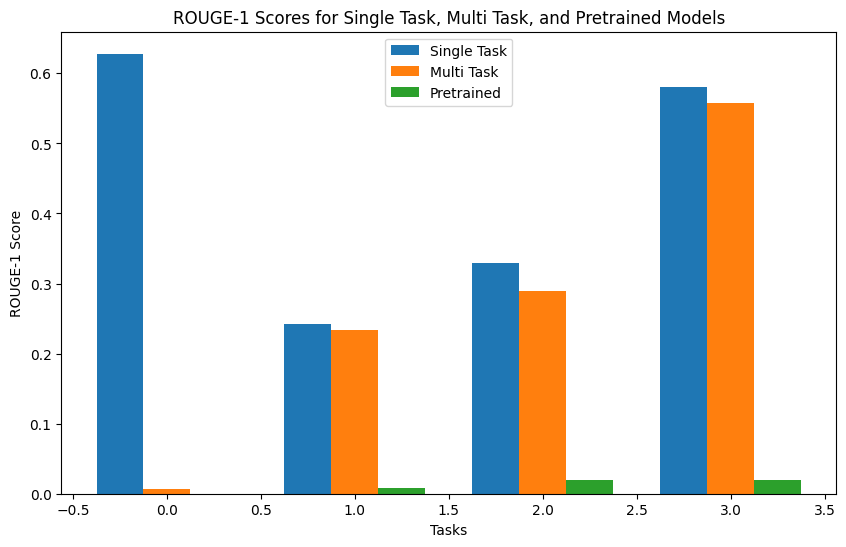

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 6))
x = np.arange(len(tasks))  # the label locations
width = 0.25  # the width of the bars
plt.bar(x - width, results_single_task, width, label='Single Task', color='#1f77b4')
plt.bar(x, results_multi_task, width, label='Multi Task', color='#ff7f0e')
plt.bar(x + width, results_pretrained, width, label='Pretrained', color='#2ca02c')

plt.xlabel('Tasks')
plt.ylabel('ROUGE-1 Score')
plt.title('ROUGE-1 Scores for Single Task, Multi Task, and Pretrained Models')
plt.legend()

In [ ]:
from safetensors.torch import load_file, save_file

lora_task1_path = 'output_centralized_tests50/model_client_0_cluster_0_round_0/adapter_model.safetensors'
lora_task2_path = 'output_centralized_tests50/model_client_1_cluster_0_round_0/adapter_model.safetensors'
lora_task3_path = 'output_centralized_tests50/model_client_2_cluster_0_round_0/adapter_model.safetensors'
lora_task4_path = 'output_centralized_tests50/model_client_3_cluster_0_round_0/adapter_model.safetensors'

lora_paths = [lora_task1_path, lora_task2_path, lora_task3_path, lora_task4_path]

# Mean of A matrices
lora_a_tensors = {}
for lora_path in lora_paths:
    lora_state_dict = load_file(lora_path)
    for key in lora_state_dict:
        if 'lora_A' in key:
            if key not in lora_a_tensors:
                lora_a_tensors[key] = []
            lora_a_tensors[key].append(lora_state_dict[key])

# Calculate mean for each lora_A matrix
lora_a_means = {}
for key, tensors in lora_a_tensors.items():
    stacked = torch.stack(tensors)
    lora_a_means[key] = torch.mean(stacked, dim=0)

# Create new adapters (Specific B with aggregated A matrices)
for lora_path in lora_paths:
    lora_state_dict = load_file(lora_path)
    lora_aggregated_state_dict = {}
    
    # Copy all tensors from the original state dict
    for key in lora_state_dict:
        if 'lora_B' in key:
            # Keep original B matrices
            lora_aggregated_state_dict[key] = lora_state_dict[key]
        elif 'lora_A' in key:
            # Replace with mean A matrices
            lora_aggregated_state_dict[key] = lora_a_means[key]
        else:
            # Copy other tensors (like bias terms if any)
            lora_aggregated_state_dict[key] = lora_state_dict[key]
            
    # Save the aggregated LoRA state dict
    save_path = os.path.join(os.path.dirname(lora_path), 'lora_SA.safetensors')
    save_file(lora_aggregated_state_dict, save_path)


In [ ]:
#test all SA with their respective test_local_dataset

for i, test_dataset in enumerate(local_datasets_test):
    lora_sa_path = f'output_centralized_tests50/model_client_{i}_cluster_0_round_0/lora_SA.safetensors'
    lora_sa_state_dict = load_file(lora_sa_path)

    model, tokenizer = get_model_and_tokenizer()
    model.load_state_dict(lora_sa_state_dict, strict=False)

    print('Eval_posting model...')
    default_evaluation(
                    model=model,
                    tokenizer=tokenizer,
                    dataset=test_dataset,
                    client_id='SA',
                    round=1, 
                    formatting_prompts_func=formatting_prompts_func,
                    script_args=None,
                    cluster_id=i,
                )

    print('Cleaning up...')
    del model
    del tokenizer
    torch.cuda.empty_cache()
    print('Done with client', i)
        

Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 3,686,400 || all params: 138,201,408 || trainable%: 2.6674
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [01:23<09:43, 83.32s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [02:44<08:10, 81.78s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [04:23<07:28, 89.71s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [06:10<06:26, 96.52s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [07:31<04:32, 90.99s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [08:44<02:49, 84.87s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [10:05<01:23, 83.66s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [11:10<00:00, 83.86s/it]


Evaluation scores: {'rouge1': np.float64(0.018755516603976778), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.018719413459389322), 'rougeLsum': np.float64(0.018724275346090617)}
Cleaning up...
Done with client 0
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 3,686,400 || all params: 138,201,408 || trainable%: 2.6674
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:50<05:53, 50.50s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [01:43<05:12, 52.02s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [02:34<04:18, 51.73s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [03:25<03:25, 51.29s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [04:16<02:33, 51.10s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [05:07<01:42, 51.08s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [05:59<00:51, 51.26s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [06:43<00:00, 50.44s/it]


Evaluation scores: {'rouge1': np.float64(0.11651993515332121), 'rouge2': np.float64(0.10428218595951291), 'rougeL': np.float64(0.11646213980832595), 'rougeLsum': np.float64(0.1165580211200409)}
Cleaning up...
Done with client 1
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 3,686,400 || all params: 138,201,408 || trainable%: 2.6674
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [01:57<13:41, 117.38s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [03:55<11:46, 117.81s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [05:32<09:01, 108.36s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [07:31<07:29, 112.38s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [09:30<05:44, 114.75s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [11:11<03:40, 110.34s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [13:29<01:59, 119.15s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [15:09<00:00, 113.66s/it]


Evaluation scores: {'rouge1': np.float64(0.2710980170221315), 'rouge2': np.float64(0.26287366475663976), 'rougeL': np.float64(0.2707099758943961), 'rougeLsum': np.float64(0.2708967245375258)}
Cleaning up...
Done with client 2
Model loaded from HuggingFaceTB/SmolLM-135M
trainable params: 3,686,400 || all params: 138,201,408 || trainable%: 2.6674
Pad token is set to <pad>.
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<|endoftext|>', '<|im_start|>', '<|im_end|>', '<repo_name>', '<reponame>', '<file_sep>', '<filename>', '<gh_stars>', '<issue_start>', '<issue_comment>', '<issue_closed>', '<jupyter_start>', '<jupyter_text>', '<jupyter_code>', '<jupyter_output>', '<jupyter_script>', '<empty_output>']}
Eval_posting model...
Evaluating model...


  0%|          | 0/8 [00:00<?, ?it/s]

Generating responses for batch 1/8


 12%|█▎        | 1/8 [00:59<06:54, 59.24s/it]

Generating responses for batch 2/8


 25%|██▌       | 2/8 [02:04<06:15, 62.61s/it]

Generating responses for batch 3/8


 38%|███▊      | 3/8 [03:04<05:07, 61.58s/it]

Generating responses for batch 4/8


 50%|█████     | 4/8 [04:09<04:11, 62.86s/it]

Generating responses for batch 5/8


 62%|██████▎   | 5/8 [05:10<03:06, 62.10s/it]

Generating responses for batch 6/8


 75%|███████▌  | 6/8 [06:18<02:08, 64.35s/it]

Generating responses for batch 7/8


 88%|████████▊ | 7/8 [07:21<01:03, 63.73s/it]

Generating responses for batch 8/8


100%|██████████| 8/8 [08:14<00:00, 61.86s/it]


Evaluation scores: {'rouge1': np.float64(0.30830521425298796), 'rouge2': np.float64(0.2969198395903758), 'rougeL': np.float64(0.3085428098071732), 'rougeLsum': np.float64(0.3084606967723609)}
Cleaning up...
Done with client 3
